# Deconstructing nonlinearities in neural networks to understand who is doing what.
##### Contact [me via Twitter](https://twitter.com/kaysonfakhar) if you have a question.

## Brief Abstract:
Artificial Neural Networks (ANNs) are in-silico models of brain circuits but with accessible nodes that make systematic manipulations feasible. However, even with such a liberty, the question of “which, when, and how much an ANN’s units causally contribute to its outcome” remained unanswered. We tackled this question by utilizing a framework that extensively and systematically perturbs ANNs. We found that ANN nodes have very distinct contribution patterns compared to their recorded activities. This stark discrepancy between nodes’ actual causal contributions and their activities points towards the limitations of inferring causal mechanisms from recorded activities only.

## A More Friendly Abstract:
Understanding who is doing what is a central theme in neuroscience. We want to know which brain regions are responsible for what cognitive functions but it's just not that straight forward. Brain is complex and almost every region is somehow involved in everything so we need to change the question to "how much" they are involved in a particular function. But even that's not enough since the regions form communities that are dynamic. So we need to add another question and ask "how much and when". This is now interesting because we can see the problem differently. Imagine this:

We have a neural network, a very abstract and accessible model of the real neuronal circuits. Thanks to this accessibility, we can record the activity of every unit and we know exactly what the neural network as a whole is doing (its cognitive function, if you will). Now here comes the interesting part. If we have the activity of each node then don't we already know "how much and when"? I mean, they're there, each node was producing $x$ much activity at each time point $t$ so what else is there to uncover? 

Here, we show that this mapping of "activity" to "the causal contribution" doesn't always hold. We first use simple arithmatic functions to show how the activity of a node dissociates from its causal contribution and then we show how large this dissociation actually is in a neural network. But what do we mean by causal contribution? You see, there are many definitions for causation among neuroscientists but we follow the intuitive "interventionist account" of causation. A unit is causally contributing to the network's outcome if by manipulating it, the outcome changes. This is a very conventional framework and you can see it everywhere in neuroscience. For example, optogenetic manipulation of some circuit resulted in disruption of some behavior so the circuit is causally involved in that behavior. But we are not satisfied with just manipulating an element (node in the neural network) and measuring the effect on behavior (changes in the network activity) because our [previous work](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1010250) show the limitations of this framework, [even if we manipulate all units](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005268). Just to mention one issue, a mere manipulation doesn't answer our "how much" question. We just know the manipulation had an effect or not. So we use a game theoretical framework called [Multi-perturbation Shapley value Analysis (MSA)](https://kuffmode.github.io/msa/) that performs a systematic manipulation of all possible combinations of elements. This means every individual unit, but also every pair, triplet, ... Then using this dataset, MSA estimates the Shapley value of a node. I won't get into the details and encourage you to read the documentations/the mentioned papers. But you can think of these Shapley values as the causal contribution of a node to the network's outcome. This answers our "how much" question but what about the other? We settled on "how much and when". Interestingly, we tweaked MSA to work with vectors instead of scalar values. So now, we have a vector of causal contributions (how much and when) for each node. We call this vector the "causal mode" of a node. Ok, so, let me emphasis on this: We now have a method that uncovers how much a node is contributing to some function at each time point. We also have their activities. The whole point of this work is to compare them and see how much a node's activity is informative for constructing a causal understanding of the network. 

I know the title says "deconstructing nonlinearities" but I haven't talked about nonlinearities here yet. I will, not now so I won't spoil the fun. Let's get into it then:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from msapy import msa, plottings as pl
from netneurotools import cluster, plotting as netplot # comment out the import line 15 in plotting if you got an error here
import bct

from itertools import product
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from echoes import ESNGenerator
from echoes.datasets import load_mackeyglasst17
from scipy.stats import ks_2samp, linregress
from copy import deepcopy
import networkx as nx
from tqdm import tqdm

I'm trying my best to have reproducible codes that produce visually appealing figures, so, these:

In [3]:
SEED = 2022
RNG = np.random.default_rng(SEED)

pl.set_style()
my_colors = ['#006685', '#3FA5C4', '#FFFFFF', '#E84653', '#BF003F']
my_complementary_colors = ['#E84653', '#BF003F','#A6587C','#591154','#260126']
colormap = sns.blend_palette(my_colors, as_cmap=True)

## Toy examples:
Here I'm hoping to make the difference between "activity" and "the causal contribution/modes" clear. For that, we generate 30 timeseries (sinusoidal waves with different amplitudes and frequencies). Imagine them as 30 nodes, if you prefer. Then we add them together to generate a new timeseries. In this case, the activity and the contributions are the same because we are simply putting things together and forming a new entity with them. See it as lego bricks, we can stack them to construct a giant Darth Vader (I wish) and unstack them while the underlying blocks are the same. This is what the `linear_case` does. 

Now imagine we do the same but then multiply the resulted timeseries by two. Here, the contribution of each node should be two times larger than its activity. We took the activites, added them together, but then we "transformed" them to form the new entity. This is what the `doubled_case` does. In this case though, the overal structure of the contributions remain the same. If a node had an activity of $x=5$ and thus it was contributing $c=5$ at time point $t$ in the `linear_case` now it is contributing $c=10$ while having the same $x=5$. 

The most interesting one is then the `non_linear_case` in which we add the timeseries together and pass them through a $tanh$ function. Now, the $tanh$ function squeezes the outcome between -1 and 1. Here, the structure of the contributions are changed since $tanh$ is not a monotonous function anymore. This means, we can't imagine how the contributions are. It might be compelling to think if $x=5$ then $c=1$ but that happens if we apply $tanh$ to the individual activities and not after we summed them together. Think of it as the lego bricks again, we make the Darth Vader but put it into a compressor. Each block is now transformed with respect to other blocks and consequently, it'll look differently if we just put that block under the compressor. 

Some of you probably figured it out already, the `non_linear_case` is one neuron in a neural network. It takes input from other connected nodes, sums them up, and finally applies a nonlinear function before passing the result to the other nodes. Here it is, nonlinearities!


In [4]:
def generate_wave_data(amp_freq_pairs, timestamps, sampling_rate):
    """A function to generate wave data from an array of amplitude and frequency pairs.
    We use this function to generate some toy examples for illustrating what causal modes are. 

    Args:
        amp_freq_pairs (ndarray): 
            numpy array of shape (n, 2) with n means the number of different amplitude and frequency pairs.
            
        timestamps (ndarray): 
            numpy array of shape (t,) with t means the number of timestamps.
            
        sampling_rate (float): 
            a float number representing the sampling rate.

    Returns:
        _type_: numpy array of shape (n, t) with n means the number of different amplitude and frequency pairs and t means the number of timestamps.
    """
    frequencies = amp_freq_pairs[:, 1, None]
    amplitudes = amp_freq_pairs[:, 0, None]
    timestamps = np.broadcast_to(
        timestamps, (amplitudes.shape[0], sampling_rate))
    data = np.sin(2 * np.pi * timestamps * frequencies) * amplitudes
    return data

def linear_case(complements):
    """the most basic case. Summing the incoming timeseries. Except for the lesioned ones. So the lesion here is defined as not contributing to this sum, and thus, not existing!

    Args:
        complements (tuples): which nodes to lesion.

    Returns:
        (ndarray): the summed up timeseries.
    """
    return data.sum(0) - data[complements, :].sum(0)

doubled_case = lambda x: linear_case(x)*2 # this is the case where we multiply the summed up signal by 2.

non_linear_case = lambda x: np.tanh(linear_case(x)) # this is the case where we pass the summed up signal through a nonlinearity, here it's tanh.



In [5]:
SAMPLING_RATE = 500
SAMPLING_INTERVAL = 1/SAMPLING_RATE
timestamps = np.arange(0, 1, SAMPLING_INTERVAL)

frequencies = np.arange(1, 10, 1.5)
amplitudes = np.arange(0.2, 2, 0.4)

amp_freq_pairs = np.array(list(map(list, product(amplitudes, frequencies))))

In [6]:
data = generate_wave_data(amp_freq_pairs, timestamps, SAMPLING_RATE)
elements = list(range(len(data)))

Let's take a look at three activities.

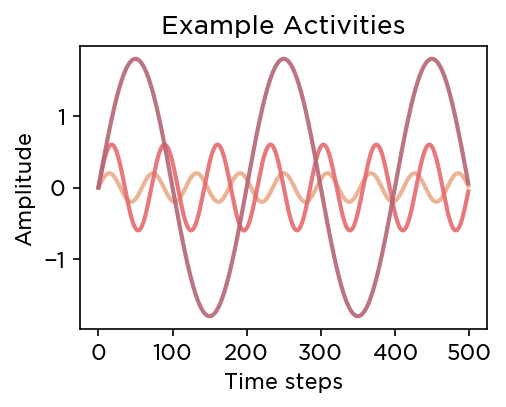

In [7]:
plt.figure(figsize=(3.5,2.5),dpi=150)
plt.plot(data[5], label="node 5",c="#EAAC8B",lw=2,alpha=0.9)
plt.plot(data[10], label="node 10",c="#E56B6F",lw=2,alpha=0.9)
plt.plot(data[25], label="node 25",c="#B56576",lw=2,alpha=0.9)
plt.title("Example Activities")
plt.xlabel("Time steps")
plt.ylabel("Amplitude");

Now let's add them up:

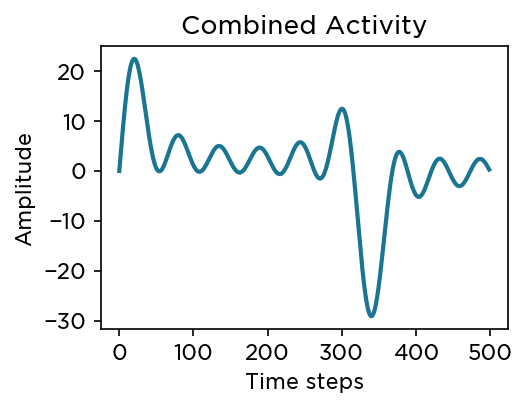

In [8]:
plt.figure(figsize=(3.5,2.5),dpi=150)
plt.plot(linear_case([]),c=my_colors[0],lw=2,alpha=0.9)
plt.title("Combined Activity")
plt.xlabel("Time steps")
plt.ylabel("Amplitude");

Here, we are using MSA to find the causal modes (contribution) of each node. Read [this](https://kuffmode.github.io/msa/#how-it-works) if you like to know what's happening under the hood. Just keep in mind that instead of a scalar we are using a vector but the rest is the same. 

In [9]:
shapley_table_linear, _, _ = msa.interface(
    elements=elements,
    n_permutations=1_000,
    objective_function=linear_case,
    n_parallel_games=-1,
    rng=RNG)
linear_modes = shapley_table_linear.groupby(level=1).mean()

Playing the games: 100%|██████████| 25556/25556 [00:00<00:00, 34948.58it/s]


In [10]:
EXAMPLE1 = 5
EXAMPLE2 = 15

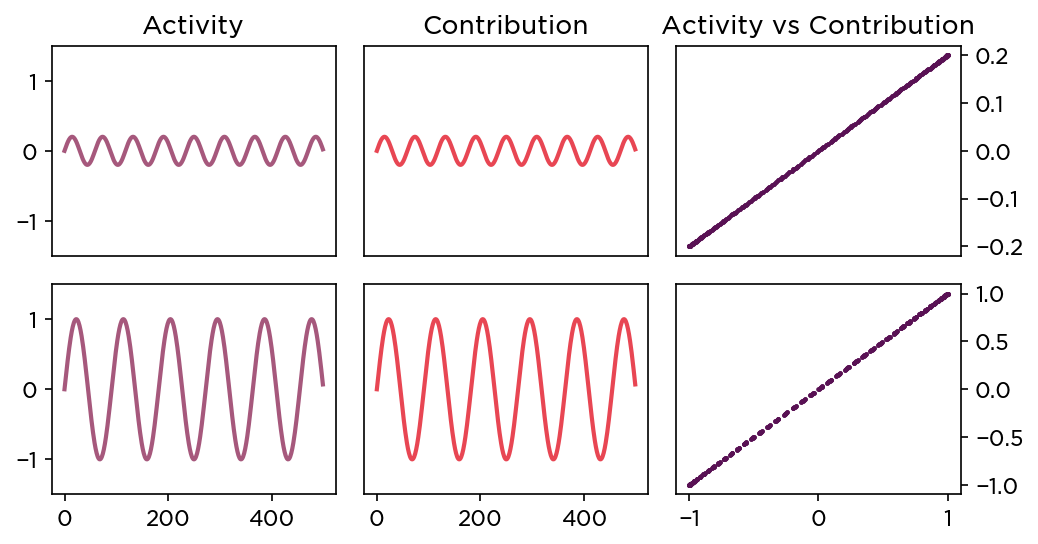

In [11]:
fig,axes = plt.subplot_mosaic(
    [['A','C','E'],
     ['B','D','F']],figsize=(7,3.5),dpi=150)
axes['A'].plot(data[EXAMPLE1], label="node 5",c=my_complementary_colors[2],lw=2)
axes['B'].plot(data[EXAMPLE2], label="node 10",c=my_complementary_colors[2],lw=2)


axes['C'].plot(linear_modes[EXAMPLE1], label="Contribution #5",c=my_complementary_colors[0],lw=2)
axes['D'].plot(linear_modes[EXAMPLE2], label="Contribution #10",c=my_complementary_colors[0],lw=2)

axes['E'].scatter(data[EXAMPLE1], linear_modes[EXAMPLE1],c=my_complementary_colors[-2],s=1.5)
axes['F'].scatter(data[EXAMPLE2], linear_modes[EXAMPLE2],c=my_complementary_colors[-2],s=1.5)

for ax in ['C','D']:
    axes[ax].yaxis.set_visible(False)
    
for ax in ['A','C','E']:
    axes[ax].xaxis.set_visible(False)

for ax in ['E','F']:
    axes[ax].yaxis.tick_right()
    
for i in ['A','B','C','D',]:
    axes[i].set_ylim([-1.5,1.5])
fig.tight_layout(pad=1)

axes['A'].title.set_text('Activity')
axes['C'].title.set_text('Contribution')
axes['E'].title.set_text('Activity vs Contribution')


As expected, the activity and the contribution is the same. Again, we added a bunch of timeseries without any transformation so the activity is the contribution. But below we exploit a very nifty axiom ("efficiency") of Shapley values. It says: ["the shapley values sum to the value of all players minus the value of none"](https://arxiv.org/abs/2207.07605). Put simply, adding all contributions gives us the outcome of the network, here, the summed up activities. For the `linear_case` this isn't something interesting because, again, the activities are the contributions. But we'll see some cool things later. For now, think of it as a sanity check. By adding the contributions we should be able to reconstruct the outcome. If not, we missed the contribution of some other elements. Here, we didn't so as you can see below, the two lines fall on each other perfectly.

Text(0, 0.5, 'Amplitude')

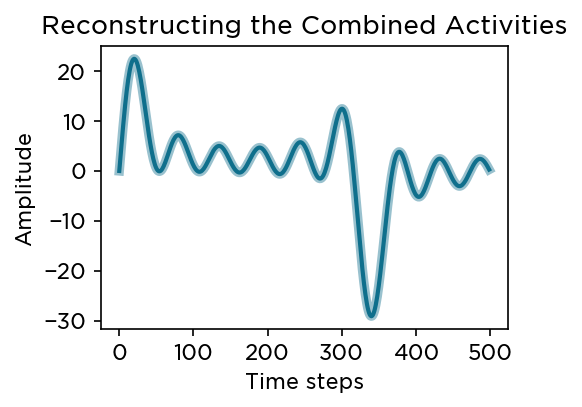

In [12]:
plt.figure(figsize=(3.5,2.5),dpi=150)
plt.plot(linear_case([]),c=my_colors[0],lw=2,alpha=0.9)
plt.plot(linear_modes.sum(1),c=my_colors[0],lw=4.5,alpha=0.4)
plt.title("Reconstructing the Combined Activities")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")

Now let's go for the second example: the `doubled_case` in which we sum the activities but we multiply the result by two. As you can see, the shape is the same and only the amplitude range is doubled.

Text(0, 0.5, 'Amplitude')

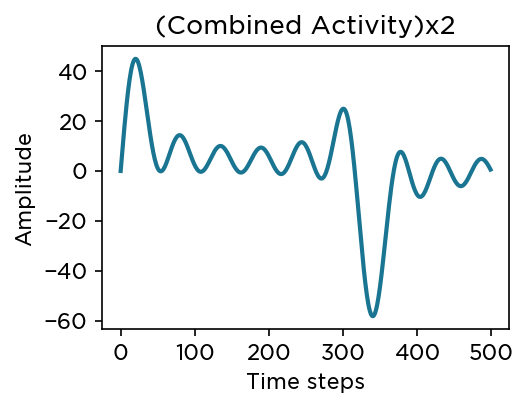

In [13]:
plt.figure(figsize=(3.5,2.5),dpi=150)
plt.plot(doubled_case([]),c=my_colors[0],lw=2,alpha=0.9)
plt.title("(Combined Activity)x2")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")

Same as above, MSA to find the contributions:

In [14]:
shapley_table_doubled, _, _ = msa.interface(
    elements=elements,
    n_permutations=1_000,
    objective_function=doubled_case,
    n_parallel_games=-1,
    rng=RNG)
doubled_modes = shapley_table_doubled.groupby(level=1).mean()

Playing the games: 100%|██████████| 25564/25564 [00:00<00:00, 31035.65it/s]


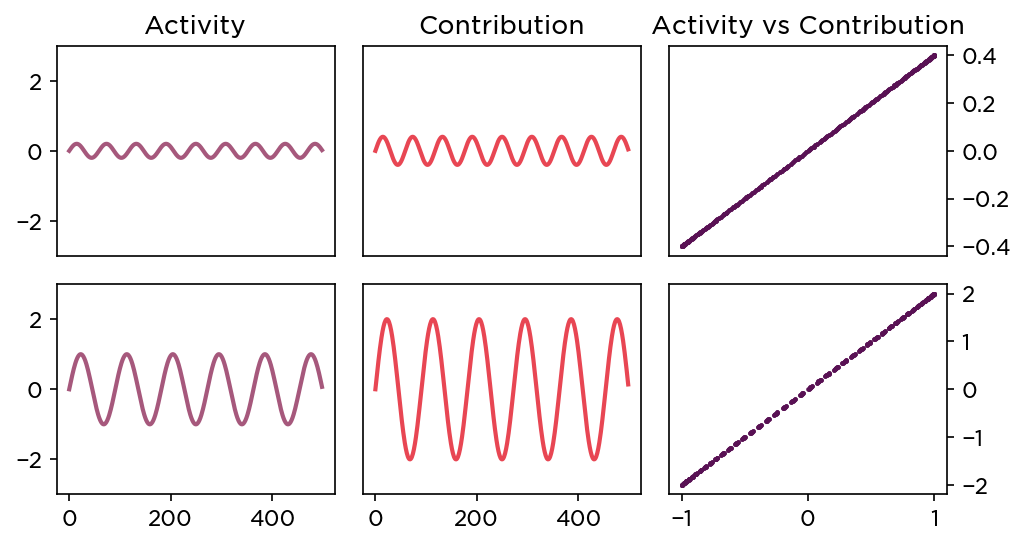

In [15]:
fig,axes = plt.subplot_mosaic(
    [['A','C','E'],
     ['B','D','F']],figsize=(7,3.5),dpi=150)
axes['A'].plot(data[EXAMPLE1], label="node 5",c=my_complementary_colors[2],lw=2)
axes['B'].plot(data[EXAMPLE2], label="node 10",c=my_complementary_colors[2],lw=2)


axes['C'].plot(doubled_modes[EXAMPLE1], label="Contribution #5",c=my_complementary_colors[0],lw=2)
axes['D'].plot(doubled_modes[EXAMPLE2], label="Contribution #10",c=my_complementary_colors[0],lw=2)

axes['E'].scatter(data[EXAMPLE1], doubled_modes[EXAMPLE1],c=my_complementary_colors[-2],s=1.5)
axes['F'].scatter(data[EXAMPLE2], doubled_modes[EXAMPLE2],c=my_complementary_colors[-2],s=1.5)

for ax in ['C','D']:
    axes[ax].yaxis.set_visible(False)
    
for ax in ['A','C','E']:
    axes[ax].xaxis.set_visible(False)

for ax in ['E','F']:
    axes[ax].yaxis.tick_right()
    
for i in ['A','B','C','D',]:
    axes[i].set_ylim([-3,3])
fig.tight_layout(pad=1)

axes['A'].title.set_text('Activity')
axes['C'].title.set_text('Contribution')
axes['E'].title.set_text('Activity vs Contribution')

Interesting, as expected, now the amplitude of the contributions are doubled while the form remained the same. You can see on the two figures at the right hand side, each value of the contributions are twice as large as its corresponding value in the activity axis. But let's get to the interesting part the `non_linear_case`:

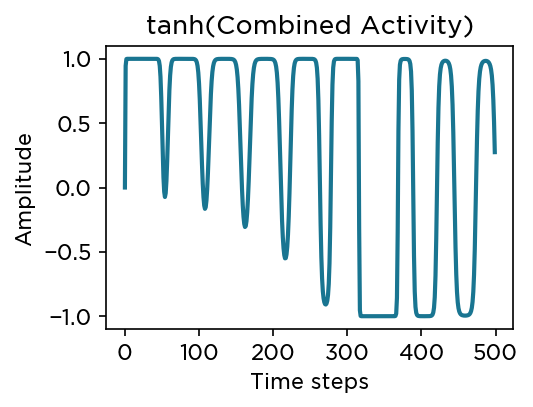

In [16]:
plt.figure(figsize=(3.5,2.5),dpi=150)
plt.plot(non_linear_case([]),c=my_colors[0],lw=2,alpha=0.9)
plt.title("tanh(Combined Activity)")
plt.xlabel("Time steps")
plt.ylabel("Amplitude");

Above, you can see how the summed up activities look like after they're passed through a $tanh$ function. Below, we use the same MSA pipeline to uncover each node's contribution to this outome.

In [17]:
shapley_table_nonlinear, _, _ = msa.interface(
    elements=elements,
    n_permutations=1_000,
    objective_function=non_linear_case,
    n_parallel_games=-1,
    rng=RNG)
nonlinear_modes = shapley_table_nonlinear.groupby(level=1).mean()

Playing the games: 100%|██████████| 25565/25565 [00:01<00:00, 21923.58it/s]


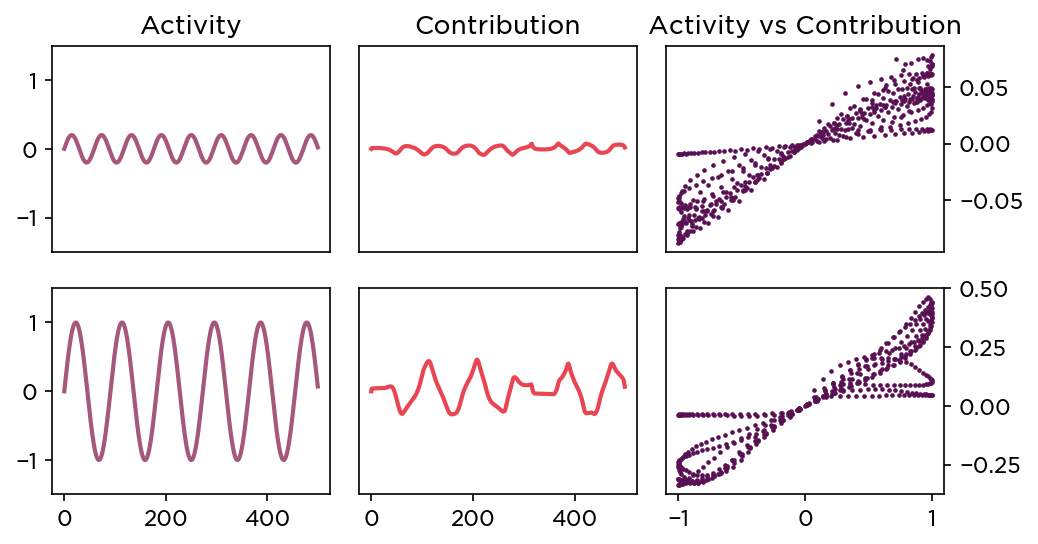

In [18]:
fig,axes = plt.subplot_mosaic(
    [['A','C','E'],
     ['B','D','F']],figsize=(7,3.5),dpi=150)
axes['A'].plot(data[EXAMPLE1], label="node 5",c=my_complementary_colors[2],lw=2)
axes['B'].plot(data[EXAMPLE2], label="node 10",c=my_complementary_colors[2],lw=2)


axes['C'].plot(nonlinear_modes[EXAMPLE1], label="Contribution #5",c=my_complementary_colors[0],lw=2)
axes['D'].plot(nonlinear_modes[EXAMPLE2], label="Contribution #10",c=my_complementary_colors[0],lw=2)

axes['E'].scatter(data[EXAMPLE1], nonlinear_modes[EXAMPLE1],c=my_complementary_colors[-2],s=1.5)
axes['F'].scatter(data[EXAMPLE2], nonlinear_modes[EXAMPLE2],c=my_complementary_colors[-2],s=1.5)

for ax in ['C','D']:
    axes[ax].yaxis.set_visible(False)
    
for ax in ['A','C','E']:
    axes[ax].xaxis.set_visible(False)

for ax in ['E','F']:
    axes[ax].yaxis.tick_right()
    
for i in ['A','B','C','D',]:
    axes[i].set_ylim([-1.5,1.5])
fig.tight_layout(pad=1)

axes['A'].title.set_text('Activity')
axes['C'].title.set_text('Contribution')
axes['E'].title.set_text('Activity vs Contribution')

Interesting! As you can see, the contributions are very different. I mean, they still roughly follow the same structure but the relationship between the activiy and the contribution is no longer linear (the right column) and no longer intuitive. To me, the interesting part of this figure is the middle column. I don't think we can produce that timeseries with a simple function anymore. I don't think we can also find a simple function that does the transformation for us (activity -> function -> contribution) because this complex shape is the result of applying a nonlinear function to a summed up timeseries. With MSA we uncover how this procedure impacted the acivities. But that's not all, below you can see the beauty of that nifty axiom again. By adding all of those contributions, we reconstructed the outcome. Also we can interpret it the otherway around: **with MSA we deconstructed the outcome to its contributing components.** Now the title should make more sense. We just had an instance of "deconstructing nonlinearities" but not in a neural network. That's what we'll do next.

Text(0, 0.5, 'Amplitude')

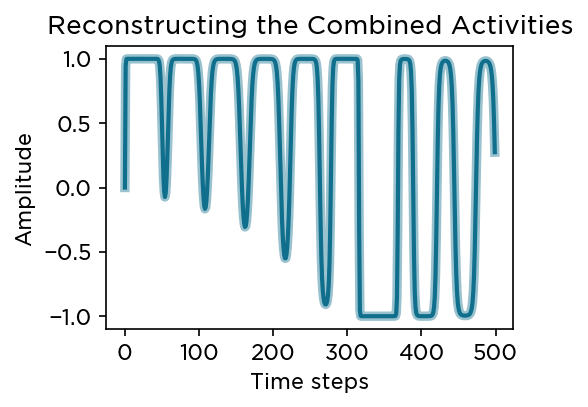

In [19]:
plt.figure(figsize=(3.5,2.5),dpi=150)
plt.plot(non_linear_case([]),c=my_colors[0],lw=2,alpha=0.9)
plt.plot(nonlinear_modes.sum(1),c=my_colors[0],lw=4.5,alpha=0.4)
plt.title("Reconstructing the Combined Activities")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")

## Deconstructing nonlinearities in a neural network
First a note on the network. For detailed information you can read [this work](https://arxiv.org/abs/2205.11947) but to briefly explain what's what: The network is an Echo State Network (ESN) in which the hidden layer remains fixed durin the training. The training happens only in the output layer (here is a linear regression) and the task is to predict the future values of the input timeseries (from the Mackey-Glass chaotic oscilator). The hidden layer usually is randomly connected but here we used a small-world topology since the network is supposed to model a local neuronal circuit. Why time series prediction then? I argue that this is actually a biologically plausible task in that level of organization if we agree with the predictive coding framework, which for now, we do!

Below we will instantiate, train, and fit the network:

In [20]:
mackey_ts = load_mackeyglasst17()
y_train, y_test = train_test_split(mackey_ts[:2500],
                                   train_size=2000,
                                   test_size=500,
                                   shuffle=False)

y_train_validate, y_test_validate = train_test_split(mackey_ts[:3500],
                                                     train_size=3000,
                                                     test_size=500,
                                                     shuffle=False)

# Constructing connectomes and defining the parameters
rng = np.random.default_rng(seed=SEED)
smallworld = nx.generators.watts_strogatz_graph(36, 6, 0.4, seed=SEED)
connectivity_matrix = nx.to_numpy_array(smallworld)

ser_connectome = connectivity_matrix * rng.uniform(low=0.1,
                                          high=1,
                                          size=(len(connectivity_matrix), len(connectivity_matrix)))

# randomly assigning weights 50 times to have 50 ESN connectomes. This'll make the network more robust.
esn_weights = [connectivity_matrix * rng.uniform(low=-0.5,
                                        high=0.5,
                                        size=(len(connectivity_matrix), len(connectivity_matrix))) for _ in range(50)]

parameter_space = list(ParameterGrid({'radius': np.linspace(0.5, 1, 20),
                                      'W': esn_weights}))
esn = ESNGenerator(n_steps=500,
                   spectral_radius=None,  # to be filled during the hyperparameter tuning
                   leak_rate=0.1,
                   random_state=SEED,
                   W=None,  # to be filled during the hyperparameter tuning
                   W_fb=rng.integers(-1, 1, len(connectivity_matrix)).reshape(-1, 1),
                   W_in=rng.uniform(-1, 1, len(connectivity_matrix)).reshape(-1, 1),
                   bias=0.001)

# Finding the best weights and spectral radius (hyperparameter tuning):
for parameters in tqdm(parameter_space,
                       total=len(parameter_space),
                       desc='Optimizing hyperparams: '):
    esn.spectral_radius = parameters['radius']
    esn.W = parameters['W']
    esn.fit(X=None, y=y_train)
    y_pred = esn.predict()
    parameters.update({'error': mean_squared_error(y_test, y_pred)})

optimum_params = min(parameter_space, key=lambda x: x['error'])  # the combination with the minimum MSE

Optimizing hyperparams: 100%|██████████| 1000/1000 [00:36<00:00, 27.71it/s]


In [21]:
# testing the network.
esn.spectral_radius = optimum_params['radius']
esn.W = optimum_params['W']
esn.store_states_pred=True
esn.fit(X=None, y=y_train_validate)

y_pred = esn.predict()
mse = mean_squared_error(y_test_validate, y_pred)

print(f'MSE: {mse:.2}, Optimal Spectral Radius: {optimum_params["radius"]:.2}')

MSE: 0.0049, Optimal Spectral Radius: 0.66


As you can see the MSE is actually pretty good. Remember our network has only 36 nodes here so I'd say this MSE is quite impressive! Now we define the lesioning function. Again, more details on this can be found [in the documentation](https://kuffmode.github.io/msa/index.html) but briefly, this function perturbs the target nodes by setting their connection weights to zero. Which ones are the target nodes? MSA provides an instruction for this.

In [23]:
def lesion_esn(complements, network, training_data):
    """the function that lesions the ESN. This is basically our "game" where we derive the causal modes from.

    Args:
        complements (tuple): which nodes to lesion at every iteration.
        network (echoes.ESNGenerator): the trained ESN object.
        training_data (ndarray): just the training data so we can fit the network to it in each iteration.

    Returns:
        (ndarray): squeezed prediction vector of the lesioned network.
    """
    # A small (technical) note on the line below: We're saying if the whole 'reservoir' is perturbed then the output is set to a vector of zeros. In reality, this is not really true.
    # The reason is that the output is also influenced by a feedback connection from the input itself (W.out_ has 37 nodes instead of 36). This is not a big deal for this work but you can see what's the difference
    # by commenting the condition below. Remember the efficiency axiom? Summing all contributions won't be equal to the outcome anymore because we're missing the contribution of the input itself.
    
    if len(complements) == len(network.W):
        return np.zeros(500) # if we lesion all the nodes, we return a vector of zeros instead of playing the game.
    
    lesioned_network = deepcopy(network)
    for target in complements:  # setting weights to zero (very close to zero due to practical issues that come with the actual zero values)
        lesioned_network.W[target,:] = 0.00001
        lesioned_network.W[:,target] = 0.00001
        lesioned_network.W_fb[target] = 0.00001
        lesioned_network.W_in[target] = 0.00001

    lesioned_network.fit(X=None, y=training_data)
    y_pred = lesioned_network.predict().squeeze()  

    return y_pred

Depending on your CPU, this might take a minute or two.

In [24]:
lesion_esn_params = {'network': esn, 'training_data': y_train_validate}
shapley_table_esn, _, _ = msa.interface(multiprocessing_method='joblib',
                                    elements=list(range(esn.n_reservoir_)),
                                    n_permutations=1_000,
                                    objective_function=lesion_esn,
                                    objective_function_params=lesion_esn_params,
                                    n_parallel_games=-1,
                                    random_seed=SEED)
esn_modes = shapley_table_esn.groupby(level=1).mean()

Playing the games: 100%|██████████| 31953/31953 [01:15<00:00, 422.06it/s]


Finally, let's see some activity vs contributions in the neural network. 

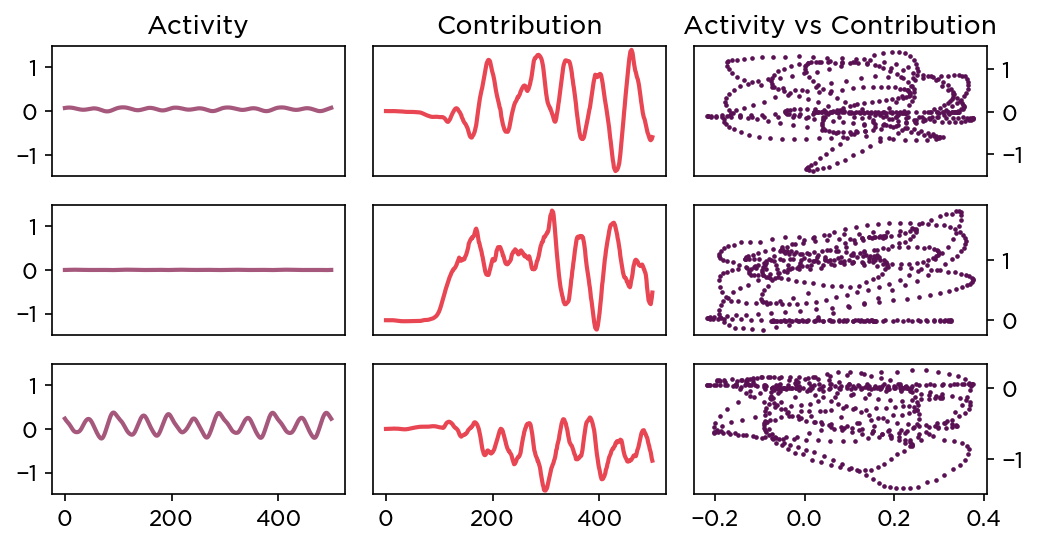

In [25]:
EXAMPLE1 = 3
EXAMPLE2 = 12
EXAMPLE3 = 32
fig,axes = plt.subplot_mosaic(
    [['A','C','E'],
     ['X','Y','Z'],
     ['B','D','F']],figsize=(7,3.5),dpi=150)
axes['A'].plot(esn.states_pred_.T[EXAMPLE1], c=my_complementary_colors[2],lw=2)
axes['X'].plot(esn.states_pred_.T[EXAMPLE3], c=my_complementary_colors[2],lw=2)
axes['B'].plot(esn.states_pred_.T[EXAMPLE2], c=my_complementary_colors[2],lw=2)

axes['C'].plot(esn_modes[EXAMPLE1], c=my_complementary_colors[0],lw=2)
axes['Y'].plot(esn_modes[EXAMPLE3], c=my_complementary_colors[0],lw=2)
axes['D'].plot(esn_modes[EXAMPLE2], c=my_complementary_colors[0],lw=2)

axes['E'].scatter(esn.states_pred_.T[EXAMPLE1], esn_modes[EXAMPLE1],c=my_complementary_colors[-2],s=1.5)
axes['Z'].scatter(esn.states_pred_.T[EXAMPLE3], esn_modes[EXAMPLE3],c=my_complementary_colors[-2],s=1.5)
axes['F'].scatter(esn.states_pred_.T[EXAMPLE2], esn_modes[EXAMPLE2],c=my_complementary_colors[-2],s=1.5)

for ax in ['C','D','Y',]:
    axes[ax].yaxis.set_visible(False)
    
for ax in ['A','C','E','X','Y','Z']:
    axes[ax].xaxis.set_visible(False)

for ax in ['E','F','Z']:
    axes[ax].yaxis.tick_right()
    
for i in ['A','B','C','D','X',]:
    axes[i].set_ylim([-1.5,1.5])
fig.tight_layout(pad=1)

axes['A'].title.set_text('Activity')
axes['C'].title.set_text('Contribution')
axes['E'].title.set_text('Activity vs Contribution')

Honestly, this is my favorite plot here. On the left column we see how the activities look like. The second row is a great example of a node that would have been classified as "non contributing" but actually had a considerable contribution to the outcome. We also see the contributions themselves are wild! Interestingly, no node is contributing during the transition period (the first 100 time points) so that's another sanity check there. Also pay attention to the relationship between activities and contributions. There's nothing trivial there anymore. So, this begs the question: why are the activities and the contributions different? Remember how ESN works? We feed these activities to a linear regression model and train the weights of that model to produce the outcome. So, this is just another but more complicated `non_linear_case`. Let's move forward and take a look at my second favorit plot below. There, we plotted the same 'activity vs contribution' for the largest, smallest, and the median readout weight.  

/home/kayson/anaconda3/envs/cmodes/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/kayson/anaconda3/envs/cmodes/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/kayson/anaconda3/envs/cmodes/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error o

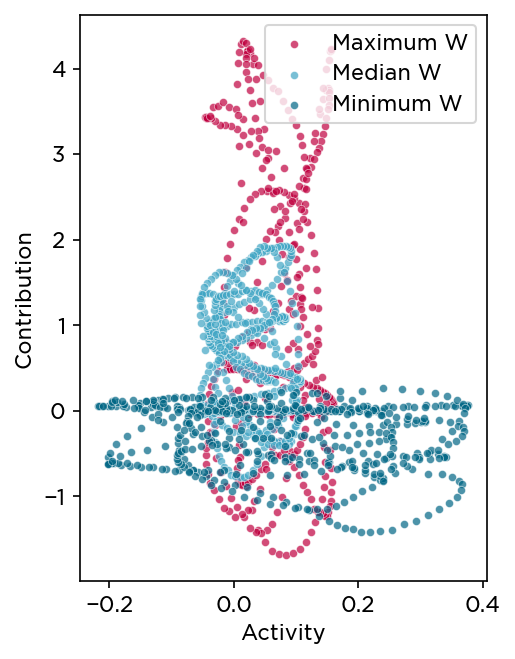

In [26]:
median_index = np.argsort(np.abs(esn.W_out_).squeeze())[len(esn.W_out_.squeeze())//2]
plt.figure(figsize=(3.5,5),dpi=150)
sns.scatterplot(esn.states_pred_.T[np.argmax(np.abs(esn.W_out_))],esn_modes[np.argmax(np.abs(esn.W_out_))].squeeze(),color=my_colors[-1],alpha=0.7,s=15,label='Maximum W')
sns.scatterplot(esn.states_pred_.T[median_index],esn_modes[median_index].squeeze(),color=my_colors[1],alpha=0.7,s=15,label='Median W')
sns.scatterplot(esn.states_pred_.T[np.argmin(np.abs(esn.W_out_[0,:-1]))],esn_modes[np.argmin(np.abs(esn.W_out_[0,:-1]))].squeeze(),color=my_colors[0],alpha=0.7,s=15,label='Minimum W')
fig.legend()
plt.ylabel('Contribution')
plt.xlabel('Activity');


As you can see above, the activity of some node (red one) wasn't really fluctuating. It's mostly between 0 and 0.2 while its contribution is between -1 and 4. It's basically flat on the y-axis. The otherway around is true for the deep blue node. What makes them different is their readout weight. The red node has the largest readout weight and the deep blue node has the smallest readout weight. The median readout weight is somewhere in between plotted with the light blue circles. What does this imply? It tells us the deciding factor of the difference between acitivty of a node and its contribution is probably its assigned readout weight, which makes sense!

Text(0, 0.5, 'Amplitude')

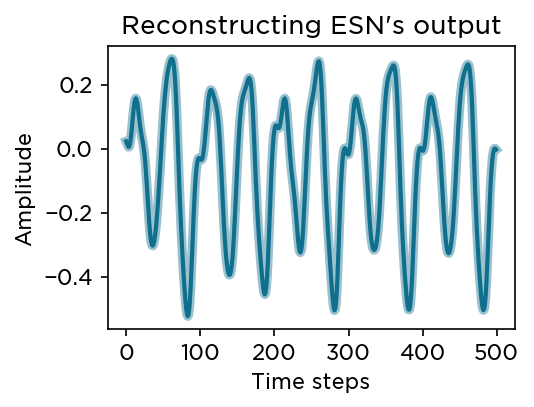

In [180]:
plt.figure(figsize=(3.5,2.5),dpi=150)
plt.plot(y_pred.squeeze(),c=my_colors[0],lw=2,alpha=0.9)
plt.plot(esn_modes.sum(axis=1),c=my_colors[0],lw=4.5,alpha=0.4)
plt.title("Reconstructing ESN's output")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")

In [186]:
mean_squared_error(y_pred.squeeze(),esn_modes.sum(axis=1))

1.0926512149963582e-30

And there's the efficiency axiom again but here it has some big implications. We finally deconstructed nonlinearities in a neural network so that by linearly adding the nodes' contributions, we could reconstruct the outcome. We now know what happens to the activity of each node after they're transformed by the linear regression model. We also have a hint of how this is happening (via the readout weights) and this finding now leads to many more questions. We'll explore some of these questions next. 

## Some thoughts:
What do we have so far? We learned that the activity of a node is equal to what it is causally contributing only when there is no transformation happening (the `linear_case`). Following that, we saw how activity and the contribution dissociate when the transformation is nonlinear and 'complicated'. For example, a $tanh$ function still keeps a mild relationship between the activity and the contribution but in a neural network this relationship is nontrivial. Finally, we learned that the readout weight is a reasonable candidate for how this dissociation. But how far we can go? What are the implications? I argue that we can't suddenly claim that the exact thing is happening in the brain but we can say whatever is happening there, it's probably far more complicated. Here, we have the simplest systems, we started with mathematical functions and moved to a neural network with a static hidden layer. The task is simple, the network is compact and simple, there is no 'plasticity', and no neurotransmitter. Our network is very descriptive, the math is clear, the node dynamics are clear, the connectome is clear, and we could perturb thousands of combinations of neurons. Still, we learned that the activity of a node is not necessarily equal to what it is contributing. The main implication is to maybe think about how much we are relying on this assumption of "activity of a node is what it does" eventhough it sounds so intuitive and logical. The problem is that the activity of a node is what it produces but not what it contributes in the end. In our case we only have one layer of transformation (the linear regression) that took these activities and solved the task with them. This is basically like if I give 100 apples to someone and the third person writes a paper on it saying: "the recipient ate 100 apple wow!" By focusing on the activities, we know what each node provides but not what it contributed. I gave 100 apple to someone but they might have trashed 99 of it. The key message, I think, is that we probably need to focus on the contributions and transformations. Let's do that a bit now: 

## Some additional analyses:
Neuroscience loves functional connectivity. The statistical similarity between the activity of two nodes is probably saying that they're doing something similar or they are from the same functional community. It's foundational for many other analyses and is heavily employed in various works. I like it too, it's simple and it can be very informative but now we have something more. We know exactly when, who is contributing how much. So let's see how can we exploit this knowledge instead of nodes' activities. Next, I'll first calculate the functional connectivity of the hidden layer, just like how it's done with the brain. I then do the same with the contributions. However, to avoid confusion we'll call it "co-fluctuation of the causal modes" because this is what it really is. I'd call functional connectivity something similar but I wasn't around when it was introduced!

In [27]:
modes_similarities = np.array(esn_modes.corr())
fc = np.corrcoef(esn.states_pred_.T)

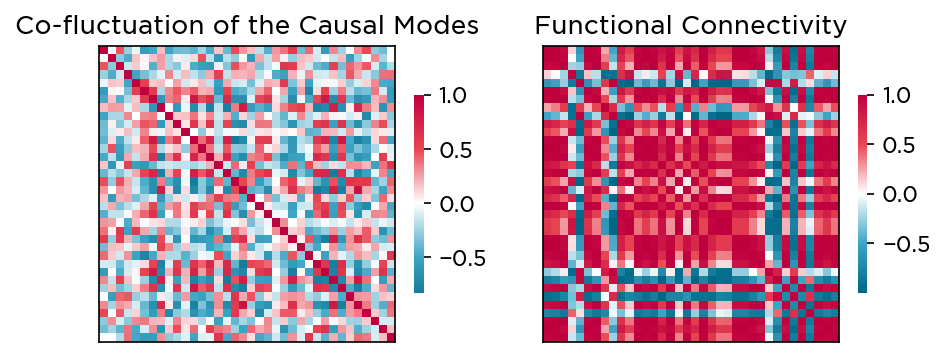

In [28]:
#cbar_ax = fig.add_axes([.92, .2, .01, .1])
fig,axes = plt.subplot_mosaic(
    [['A','B']],figsize=(7,3.5),dpi=150)
sns.heatmap(modes_similarities,square=True,center=0,
            cmap=colormap,cbar_kws={"shrink": .5},ax=axes['A'],xticklabels=False,yticklabels=False)
sns.heatmap(fc,square=True,
            cmap=colormap,center=0,cbar_kws={"shrink": .5},ax=axes['B'],xticklabels=False,yticklabels=False)
axes['A'].title.set_text('Co-fluctuation of the Causal Modes')
axes['B'].title.set_text('Functional Connectivity')

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

Cool, by looking at the functional connectivity matrix we see that the network is largly synchronized. We already have a figure above with the activities plotted on the first column but let's have a better look here:

<AxesSubplot:>

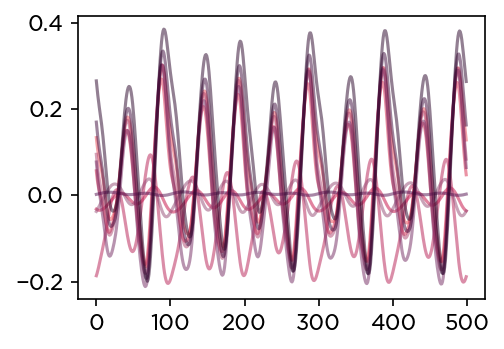

In [42]:
from_to=[25,-1]

states_range = esn.states_pred_.T[from_to[0]:from_to[1]]
activity_colormap = sns.blend_palette(my_complementary_colors, n_colors=len(states_range),as_cmap=False)

plt.figure(figsize=(3.5,2.5),dpi=150)
sns.lineplot(data=states_range.T,dashes=False,alpha=0.5,legend=False,palette=activity_colormap)


I'm not an expert but seems like this is not a good thing if you are training a ESN. Ideally, each node should pick up something different from the input and the reservoir should form diverse representations. Here, they are diverse but not as diverse as they should (ideally) be. We can see even in these few nodes, many are fluctuating together with some delay, some are doing the opposite and some are fluctuating in-between with a smaller amplitude. On the other hand, if you look back at the co-fluctuation matrix of the causal modes, you see a lot more things happening so let's plot some of them too to have a closer look:

<AxesSubplot:xlabel='timestamp'>

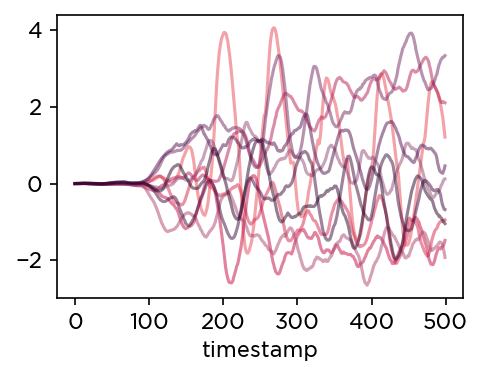

In [43]:
mode_range=esn_modes.T[from_to[0]:from_to[1]]
plt.figure(figsize=(3.5,2.5),dpi=150)
sns.lineplot(data=mode_range.T,dashes=False,alpha=0.5,legend=False,palette=activity_colormap)

First of all, again, look how none of the nodes are contributing during the transition period (cool, right?) but also they are far more diverse. We can't really find even two nodes that are distinguishably similar and that translates to a richer co-fluctuation matrix. So what can we do next? We can stop eyeballing these and put numbers on them. We can find communities and sort the matrices based on those communities. Here, a node is assigned to a community if it has many positive connections (derived from the matrices above, not the connectome itself) with other nodes in the same community while has negative connections with other communities. So a communitiy here means a collection of nodes that are similar to each other and dissimilar to the others. There's [this beautiful review](https://www.annualreviews.org/doi/full/10.1146/annurev-psych-122414-033634) if you're interested in learning more.

In [44]:
GAMMA = 1.
mode_communities = [bct.clustering.modularity_louvain_und_sign(modes_similarities, gamma=GAMMA)[0] for _ in range(1000)]
mode_consensus = cluster.find_consensus(np.column_stack(mode_communities), seed=SEED)
fc_communities = [bct.clustering.modularity_louvain_und_sign(fc, gamma=GAMMA)[0] for _ in range(1000)]
fc_consensus = cluster.find_consensus(np.column_stack(fc_communities), seed=SEED)

Now let's take a look at the communities. It's the same matrices but now sorted according to their assigned communities.

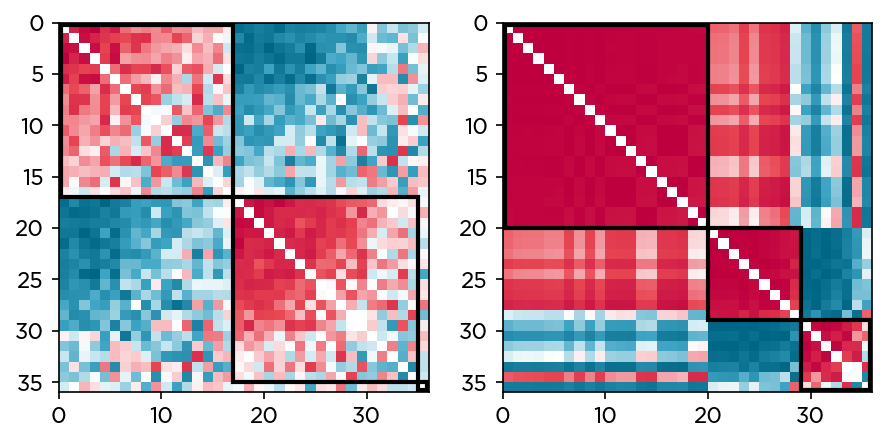

In [45]:
fig,axes = plt.subplot_mosaic([['A','B']],figsize=(7,3.5),dpi=150)
netplot.plot_mod_heatmap(modes_similarities, mode_consensus, cmap=colormap,ax=axes['A'],cbar=False)
netplot.plot_mod_heatmap(fc, fc_consensus, cmap=colormap,ax=axes['B'],cbar=False,)
for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

Please ignore the ticks and as you can see, our hunch was correct about the functional connectivity communities (right). There are three and one is pretty much anticorrelated with the other two. Interestingly, there are two communities (left) in the contributions + alone node. I still need to read and think more about the intercommunity structure of the causal modes but to me, it looks like that they have a scale-free topology. Not sure why and what does it mean tho! 

#### Participation Coefficient
We can do more now. After assigning communities, we can say that there are two classes of contribution that internally look close but look different from each other. Then we can compute the participation coefficient of each node (again, take a look at the review paper I refered to above). Participation coefficient quantifies the amount of which a node is connected to its own community vs the others. If it's near zero then the node is mostly connected to other nodes in its community and if it's near one then the node is equally connected to other communities as well. However, I don't think we can interpret it here as such since the communities are not structural. A node is connected to its community doesn't really mean a connection but a stronger similarity. So I think it makes more sense to interpret participation coefficient as "how much contribution of a node is similar to contribution of other nodes in its community vs those from the other communities". So now a participation coefficient of 1 can be interpreted as a contribution that is equally and strongly similar to contributions from nodes in other communities (here two).

#### KS distance
Another very cool thing we can do with what we have is to measure how much activity of a unit is transformed. In other words, we can measure a distance between the activity of a node and its contribution. Here we used [Kolmogorov–Smirnov (KS)](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) distance that is a statistical distance between two cumulative distributions. The benefit of using this distance over metrict like correlation and mutual information is that it's bounded between 0 and 1. So the distance of 1 indicates a complete transformation and a distance of 0 indicates no transformation at all. Let's give them a go:

In [59]:
# for the participation coefficient
nonnegative_modes = modes_similarities.copy()
nonnegative_modes[modes_similarities<0] = 0

nonnegative_fc = fc.copy()
nonnegative_fc[fc<0] = 0

In [61]:
# I'll make it pretty later, I swear. 
ks_index=[]
for i in range(len(esn_modes.T)):
    temp=[]
    temp,_=ks_2samp(np.array(esn.states_pred_.T[i]),np.array(esn_modes[i]))
    ks_index.append(temp)


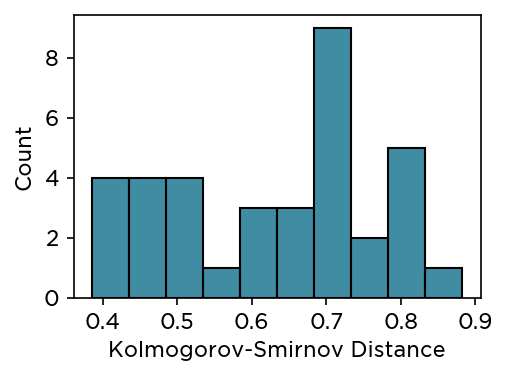

In [76]:
plt.figure(figsize=(3.5,2.5),dpi=150)
sns.histplot(ks_index, color=my_colors[0],bins=10)
plt.xlabel('Kolmogorov-Smirnov Distance');

The distribution of distances tells us that there is a minimum of 0.4 so there is no node with no transformation. We have a range of moderate to heavy transformations with a peak around 0.7-0.8. This indicates that the activity of most nodes are heavily transformed. A very interesting project would be to see why? What predicts this transformation? We just tried one here, the participation coefficient (below) but I think this by itself can be improved in many different ways. For example, what happens if we replace KS distance with something else? I played around with some metrics and none really work because of the very nonlinear relationship between the activities and the contributions but there might be something more intuitive. Anyway, let's plot the last real plot:

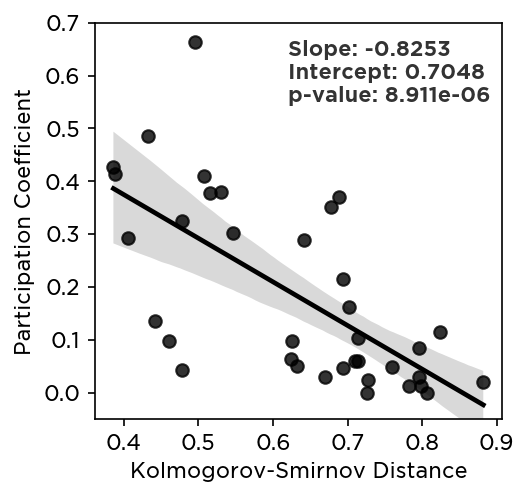

In [92]:
pc = bct.participation_coef(nonnegative_modes, mode_consensus)
regression_stats=linregress(ks_index,pc)
data=pd.DataFrame({'ks':ks_index,'pc':pc})
plt.figure(figsize=(3.5,3.5),dpi=150)
sns.regplot(x='ks',y='pc',data=data,truncate=True,color='k')
plt.ylabel('Participation Coefficient')
plt.xlabel('Kolmogorov-Smirnov Distance')
plt.text(0.62,0.55,f"Slope: {regression_stats[0]:.4}\nIntercept: {regression_stats[1]:.4}\np-value: {regression_stats[3]:.4}",color='k',fontweight='bold',alpha=0.8)
plt.ylim([-0.05,0.7]);

I find this plot a bit hard to interpret even though the relationship is pretty strong. I think it means the more the contribution of a node is similar to those from other communities (large participation coefficient), the less it is transformed (small KS distance). I can't really say why and I need to think a bit more on it!

## Some exploratory analyses:
Just tried out a number of things but nothing that I can make sense of so I'll just leave them here mostly for others not to repeat them!

<AxesSubplot:>

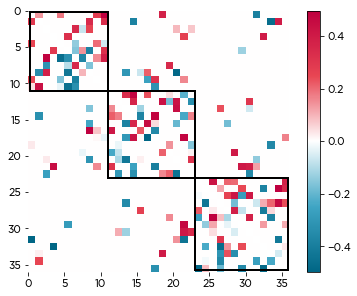

In [93]:
structural_communities = [bct.community_louvain(connectivity_matrix, gamma=GAMMA)[0] for n in range(1000)]

structural_consensus = cluster.find_consensus(np.column_stack(structural_communities), seed=SEED)
netplot.plot_mod_heatmap(esn.W, structural_consensus, cmap=colormap)

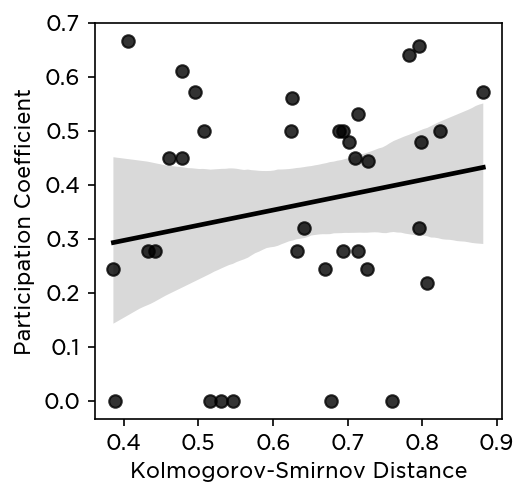

In [95]:
pc_structural = bct.participation_coef(connectivity_matrix, structural_consensus)
structural_data=pd.DataFrame({'ks':ks_index,'pc':pc_structural})
plt.figure(figsize=(3.5,3.5),dpi=150)
sns.regplot(x='ks',y='pc',data=structural_data,truncate=True,color='k')
plt.ylabel('Participation Coefficient')
plt.xlabel('Kolmogorov-Smirnov Distance');


In [96]:
linregress(ks_index,pc_structural)

LinregressResult(slope=0.2804534556003108, intercept=0.18502705236697792, rvalue=0.19020835615225815, pvalue=0.2665015125586303, stderr=0.24825036045781826, intercept_stderr=0.16064810041314712)

In [97]:
from network_control.utils import matrix_normalization
from network_control.metrics import ave_control, modal_control
A = matrix_normalization(np.abs(esn.W), c=1, version='discrete')
mc = modal_control(A)
ac = ave_control(A)

Normalizing A for a discrete-time system


/home/kayson/anaconda3/envs/cmodes/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/kayson/anaconda3/envs/cmodes/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

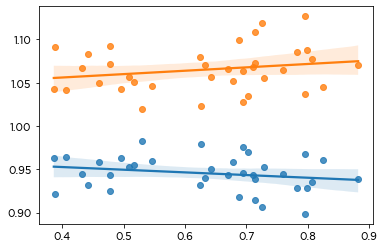

In [99]:
sns.regplot(ks_index,mc)
sns.regplot(ks_index,ac)
